### figure 1A
Number of outliers per individual (avg/std bar), for each population, for z >= 3 and z>=2

In [2]:
print('hi')

[1] "hi"


In [1]:
#data_dir = "/Volumes/T7"
data_dir = "/oak/stanford/groups/smontgom/erobb/data"

pops = c("ESN", "GWD", "LWK", "MKK", "MSL", "YRI")
dframe = data.frame()

for (pop in pops) {
    zscore_file = sprintf('%s/eoutliers/%s_exprResiduals.tsv', data_dir, pop)
    zscores = read.table(zscore_file, header=1, row.names=1)

    out_z2 = colSums(zscores > 2)
    out_z3 = colSums(zscores > 3)
    popdf_z2 = data.frame(Outliers=out_z2, Threshold="Z>2", Population=pop)
    popdf_z3 = data.frame(Outliers=out_z3, Threshold="Z>3", Population=pop)

    dframe = rbind(dframe, popdf_z2, popdf_z3)
}


In [3]:
avg_z2 = mean(dframe[dframe$Threshold == "Z>2",]$Outliers)
avg_z3 = mean(dframe[dframe$Threshold == "Z>3",]$Outliers)
mx = max(dframe$Outliers)
s=seq(min(dframe$Outliers), max(dframe$Outliers), by = 100)

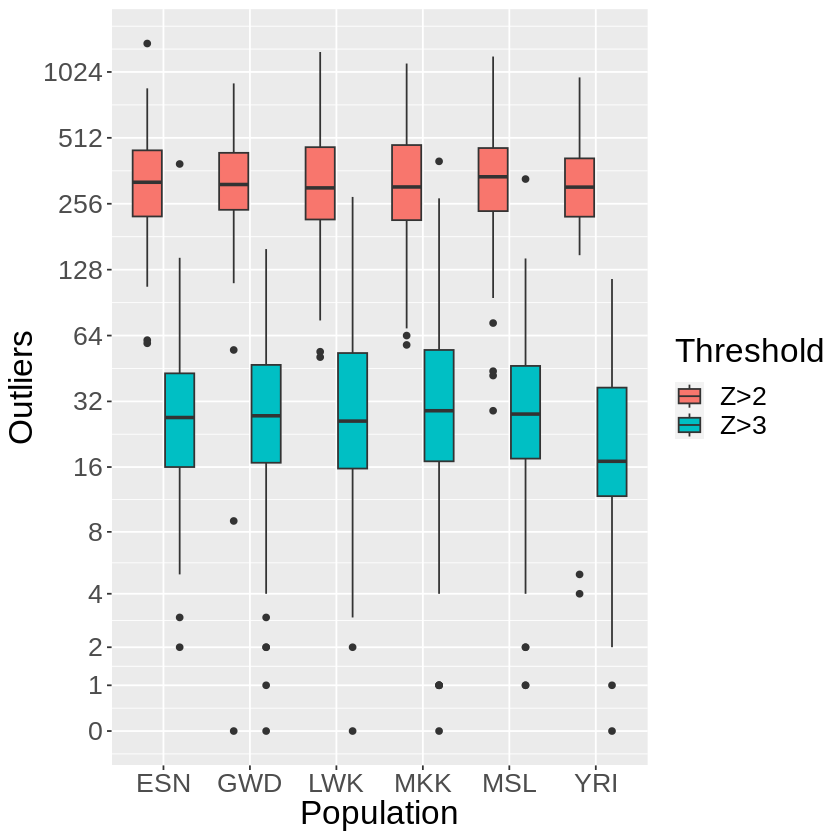

In [4]:
library(ggplot2)
base=2
top=round(log(max(dframe$Outliers), base=base))
p <- ggplot(dframe, aes(y=Outliers, x=Population, fill=Threshold)) + 
  scale_y_continuous(trans=scales::pseudo_log_trans(base = base), 
                     breaks=round(c(0,base^(0:top)))) +
  geom_boxplot() +  
  theme(text = element_text(size = 20))
p

### 1B
“rare variant enrichment”, histogram of AF (presumably the minimum over all variants in the gene, per individual) vs RR (relative risk, in our case z-score) 

In [1]:
library(plyr)
library(ggplot2)

# source: http://www.sthda.com/english/wiki/ggplot2-line-plot-quick-start-guide-r-software-and-data-visualization
data_summary <- function(data, varname, groupnames){
  require(plyr)
  summary_func <- function(x, col){
    c(mean = mean(x[[col]], na.rm=TRUE),
      sd = sd(x[[col]], na.rm=TRUE))
  }
  data_sum<-ddply(data, groupnames, .fun=summary_func,
                  varname)
  data_sum <- rename(data_sum, c("mean" = varname))
  return(data_sum)
}


[1] "/oak/stanford/groups/smontgom/erobb/data/eoutliers/GWD_exprResiduals.tsv"
[1] "/oak/stanford/groups/smontgom/erobb/data/watershed/all.GWD.30x.ID.VEP.bedtools.rare.ws.gencode.phyloP.agg.eout.pairs.tsv"


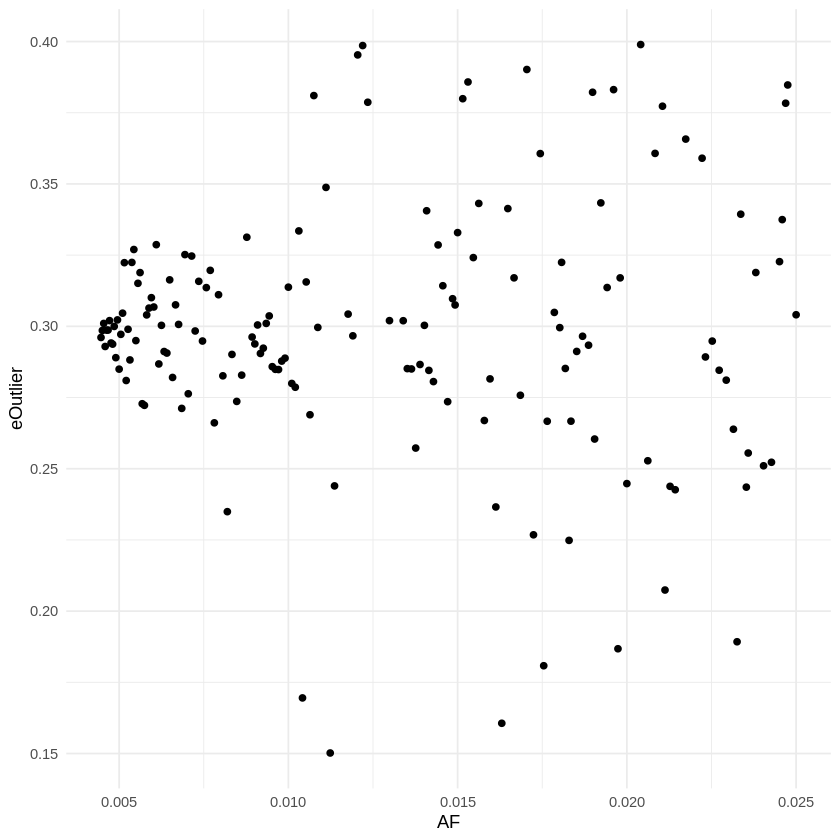

In [11]:
data_dir = "/oak/stanford/groups/smontgom/erobb/data"

# TODO maybe just show this for AFR
pop="GWD"

zscore_file = sprintf('%s/eoutliers/%s_exprResiduals.tsv', data_dir, pop)
print(zscore_file)
zscores = read.table(zscore_file, header=1, row.names=1)
row.names(zscores) = sapply(row.names(zscores), function(x) unlist(strsplit(x, "[.]"))[1], USE.NAMES=FALSE)

# ws_file = sprintf('%s/watershed/AF.all.%s.hg38a.ID.ba.VEP.rare.ws.tsv', data_dir, pop)
# ws_file = sprintf("%s/watershed/AF.all.%s.hg38a.ID.ba.VEP.gencode.phyloP.rare.agg.eout.ws.tsv", data_dir, pop)
ws_file = sprintf("%s/watershed/all.%s.30x.ID.VEP.bedtools.rare.ws.gencode.phyloP.agg.eout.pairs.tsv", data_dir, pop)
print(ws_file)
df = read.table(ws_file, sep="\t", fill=T, header=1)
row.names(df) = paste(df$SubjectID, df$GeneName)


df_rr = df[, c("AF", "eOutlier")]
df_rr <- data_summary(df_rr, varname="eOutlier", 
                    groupnames=c("AF"))

# TODO this is only plotting rare variants, do we want to see higher AF also?
ggplot(df_rr, aes(x=AF, y=eOutlier)) + 
    #geom_errorbar(aes(ymin=eOutlier-sd, ymax=eOutlier+sd)) +
    #geom_line() + 
    geom_point() +
   theme_minimal()

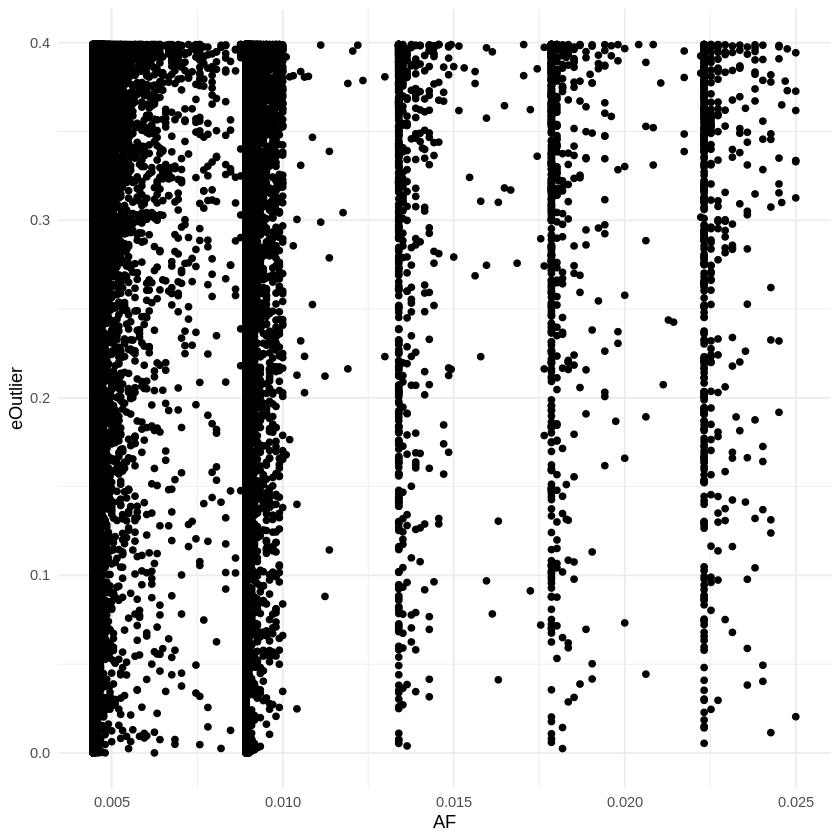

In [8]:

ggplot(df_rr, aes(x=AF, y=eOutlier)) + 
    #geom_errorbar(aes(ymin=eOutlier-sd, ymax=eOutlier+sd)) +
    #geom_line() + 
    geom_point() +
   theme_minimal()

### 1C

In [1]:
#pops = c("ESN", "GWD", "LWK", "MSL", "YRI")
pops = c("ESN", "GWD", "LWK")
aucs = c()
aucs_p241 = c()
gam_aucs = c()
seeds = c()
pops_ = c()
for (s in 0:5){
for (pop in pops) {
    print(sprintf("RIVER_n1_30x_%s_seed%s_evaluation_object.rds", pop, s))
    ws_obj <- readRDS(sprintf("RIVER_n1_30x_%s_seed%s_evaluation_object.rds", pop, s))
    #ws_p241_obj = readRDS(sprintf("RIVER_n1_%s_phyloP-241_seed%s_evaluation_object.rds", pop, s))
    aucs = c(aucs, ws_obj$auc[[1]]$evaROC$watershed_pr_auc)
    gam_aucs = c(gam_aucs, ws_obj$auc[[1]]$evaROC$GAM_pr_auc)
    #aucs_p241 = c(aucs_p241, ws_p241_obj$auc[[1]]$evaROC$watershed_pr_auc)
    seeds = c(s, seeds)
    pops_ = c(pop, pops_)
}
}

df_ws = data.frame(AUC=aucs, Population=pops_, Model="RIVER",Seed=seeds)
#df_ws_p241 = data.frame(AUC=aucs_p241, Population=pops_, Model="RIVER_phyloP241",Seed=seeds)
df_gam = data.frame(AUC=gam_aucs, Population=pops_, Model="GAM", Seed=seeds)
#df = rbind(df_ws, df_gam, df_ws_p241)
df = rbind(df_ws, df_gam)

[1] "RIVER_n1_30x_ESN_seed0_evaluation_object.rds"
[1] "RIVER_n1_30x_GWD_seed0_evaluation_object.rds"
[1] "RIVER_n1_30x_LWK_seed0_evaluation_object.rds"
[1] "RIVER_n1_30x_ESN_seed1_evaluation_object.rds"
[1] "RIVER_n1_30x_GWD_seed1_evaluation_object.rds"
[1] "RIVER_n1_30x_LWK_seed1_evaluation_object.rds"
[1] "RIVER_n1_30x_ESN_seed2_evaluation_object.rds"
[1] "RIVER_n1_30x_GWD_seed2_evaluation_object.rds"
[1] "RIVER_n1_30x_LWK_seed2_evaluation_object.rds"
[1] "RIVER_n1_30x_ESN_seed3_evaluation_object.rds"
[1] "RIVER_n1_30x_GWD_seed3_evaluation_object.rds"
[1] "RIVER_n1_30x_LWK_seed3_evaluation_object.rds"
[1] "RIVER_n1_30x_ESN_seed4_evaluation_object.rds"
[1] "RIVER_n1_30x_GWD_seed4_evaluation_object.rds"
[1] "RIVER_n1_30x_LWK_seed4_evaluation_object.rds"
[1] "RIVER_n1_30x_ESN_seed5_evaluation_object.rds"
[1] "RIVER_n1_30x_GWD_seed5_evaluation_object.rds"
[1] "RIVER_n1_30x_LWK_seed5_evaluation_object.rds"


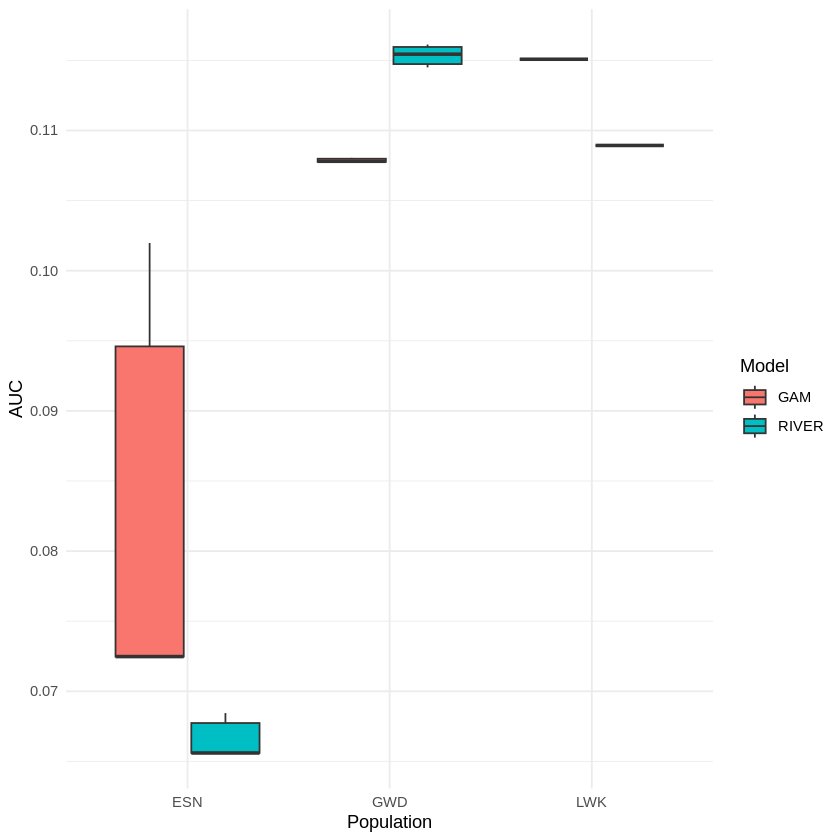

In [2]:
library(ggplot2)

# TODO add the eOutlier rate for each population to this plot, which should be comparable to the precision? Or ask Stephen this question.
# TODO plot theta with feature names, to see which features contribute the most to eOutlier score
p <- ggplot(df, aes(y=AUC, x=Population, fill=Model)) + 
  geom_boxplot() + 
  theme(text = element_text(size = 21)) +
  theme_minimal()
p



In [18]:
df_th

Features,Theta
<chr>,<dbl>
phyloP,0.0401993864
num_rare_variants,-0.0530711568
distTSS,0.0263817295
distTES,0.0250281040
3_prime_UTR_variant,-0.0251691605
5_prime_UTR_variant,0.0078178094
downstream_gene_variant,-0.0190233094
intron_variant,0.0209465285
missense_variant,-0.0050609042


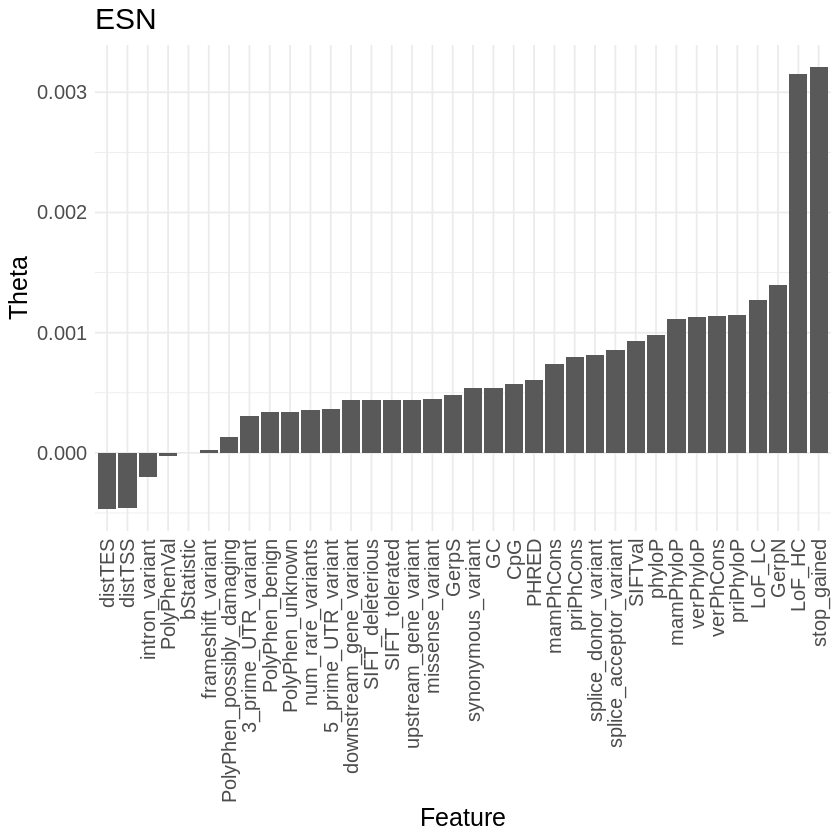

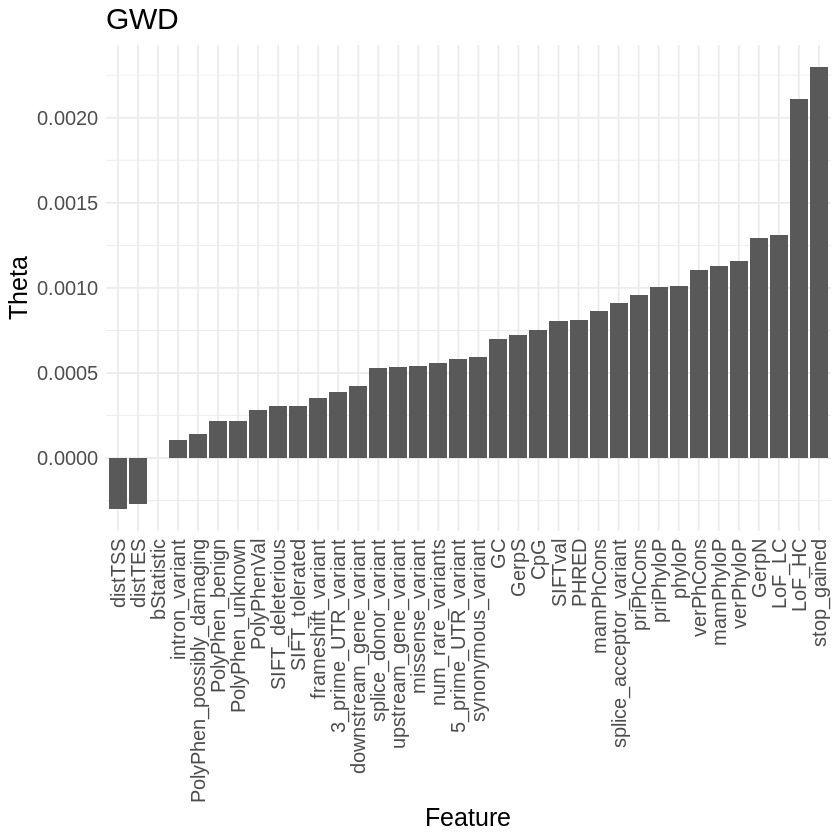

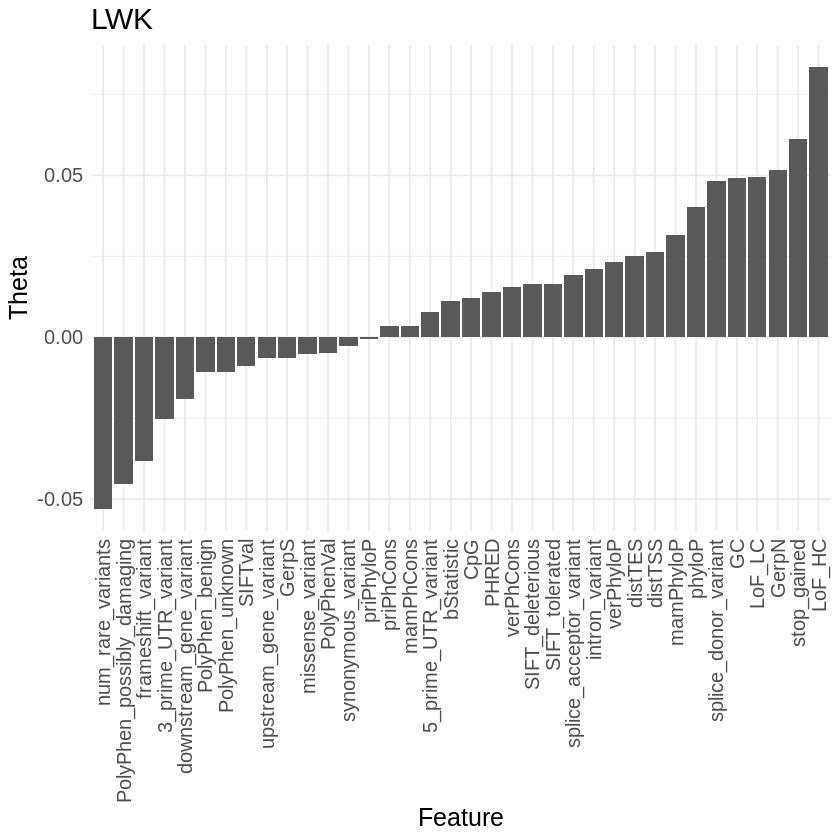

In [21]:
feats = strsplit("phyloP	num_rare_variants	distTSS	distTES	3_prime_UTR_variant	5_prime_UTR_variant	downstream_gene_variant	intron_variant	missense_variant	splice_acceptor_variant	splice_donor_variant	stop_gained	synonymous_variant	upstream_gene_variant	frameshift_variant	LoF_HC	LoF_LC	GC	CpG	SIFT_deleterious	SIFT_tolerated	SIFTval	PolyPhen_benign	PolyPhen_possibly_damaging	PolyPhen_unknown	PolyPhenVal	bStatistic	priPhCons	mamPhCons	verPhCons	priPhyloP	mamPhyloP	verPhyloP	GerpN	GerpS	PHRED", "\t")
feats = feats[[1]]

s=1
# Seems to vary a bit between populations, but not much between seeds.
# TODO Taibo's paper sorts these and plots by absolute value (Figure 4c), so I can try that for comparison.
for (pop in pops){
#for (s in 1:3){
    ws_obj <- readRDS(sprintf("RIVER_n1_30x_%s_seed%s_evaluation_object.rds", pop, s))
    #ws_obj = readRDS(sprintf("RIVER_n1_%s_phyloP-241_seed%s_evaluation_object.rds", pop, s))
    df_th = data.frame("Features"=feats, "Theta"=ws_obj$model_params$theta)
    p <- ggplot(df_th, aes(y=Theta, x=reorder(Features, Theta))) +
     geom_bar(stat="identity") +
     #coord_cartesian(xlim = c(0, 45)) +
     theme_minimal() +
     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
     theme(text = element_text(size = 15)) + 
     labs(x="Feature", y="Theta") +
     ggtitle(pop)
    print(p)
}

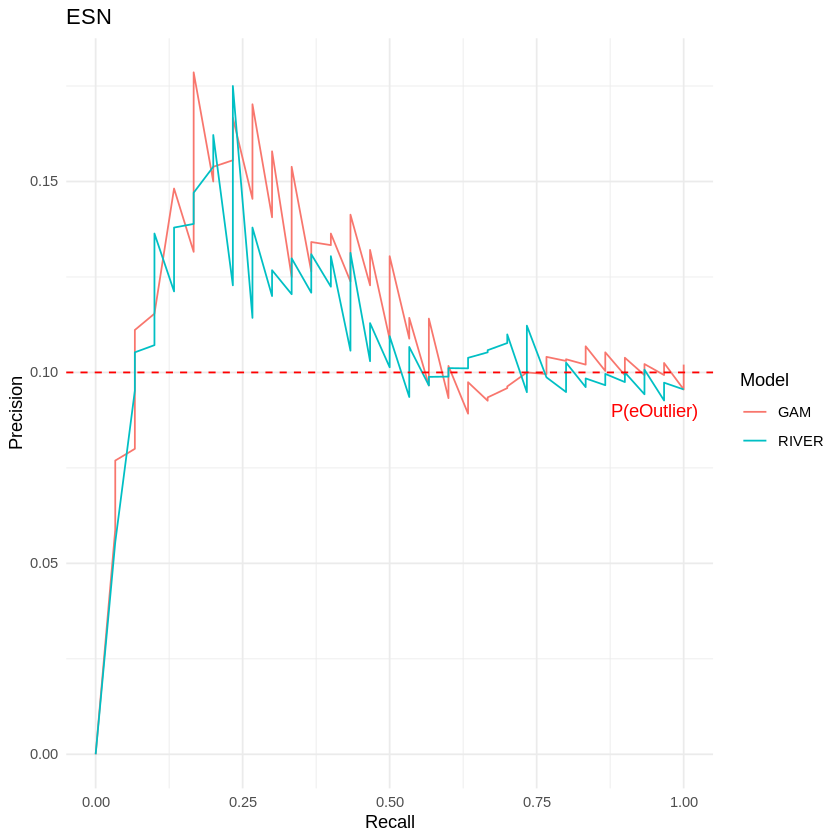

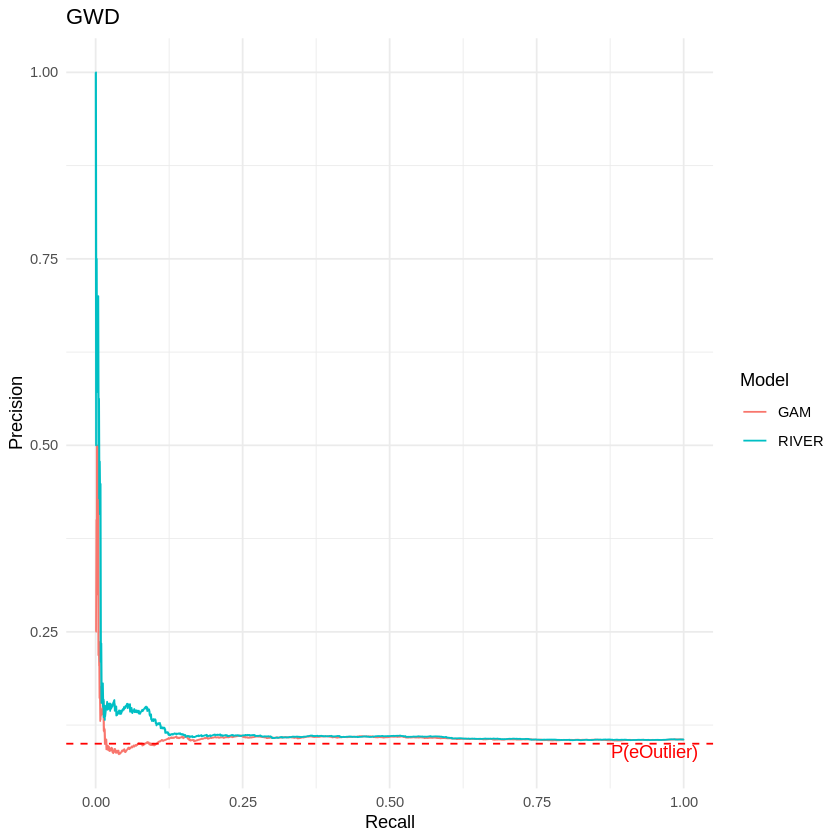

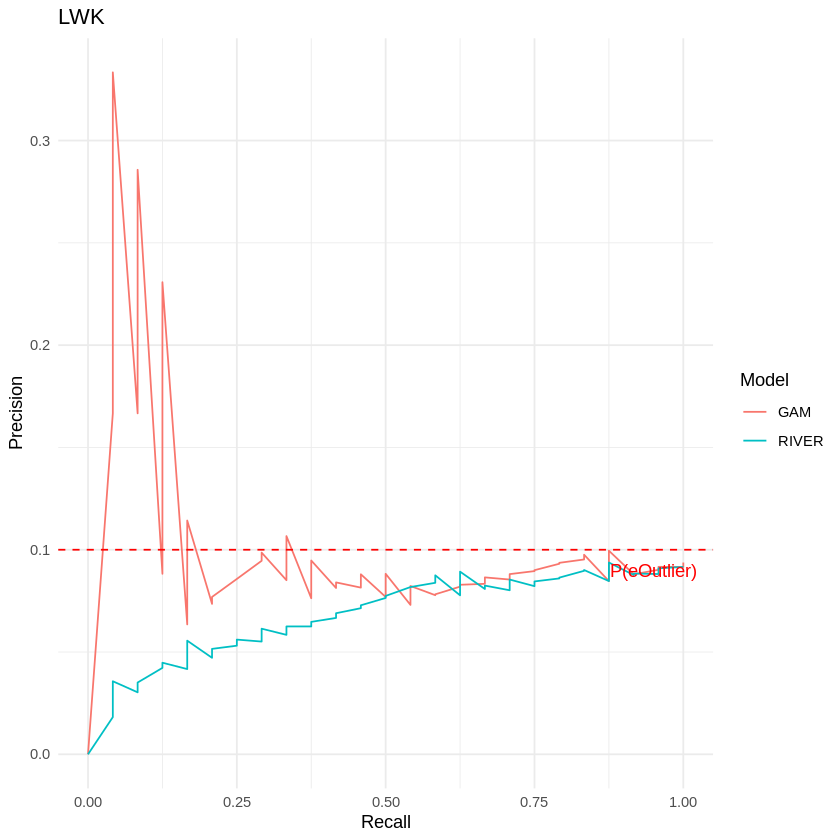

In [25]:
# These 
s=3
pops=c("ESN","GWD","LWK")
for (pop in pops) {
    ws_obj <- readRDS(sprintf("RIVER_n1_30x_%s_seed%s_evaluation_object.rds", pop, s))
    #ws_p241_obj = readRDS(sprintf("RIVER_n1_%s_phyloP-241_seed%s_evaluation_object.rds", pop, s))
    
    pr_ws = data.frame(Recall=ws_obj$auc[[1]]$evaROC$watershed_recall, Precision=ws_obj$auc[[1]]$evaROC$watershed_precision, Model="RIVER")
    #pr_ws_p241 = data.frame(Recall=ws_p241_obj$auc[[1]]$evaROC$watershed_recall, Precision=ws_p241_obj$auc[[1]]$evaROC$watershed_precision, Model="RIVER_phyloP241")
    pr_gam = data.frame(Recall=ws_obj$auc[[1]]$evaROC$GAM_recall, Precision=ws_obj$auc[[1]]$evaROC$GAM_precision, Model="GAM")
    #pr = rbind(pr_ws, pr_gam, pr_ws_p241)
    pr = rbind(pr_ws, pr_gam)
    
    p <- ggplot(pr, aes(x=Recall, y=Precision, color=Model)) + 
    geom_line() + 
    ggtitle(pop) +
    theme_minimal() +
    geom_hline(yintercept=ws_obj$outlier_prop, linetype="dashed", color = "red") +
    annotate(geom="text", x=0.95, y=ws_obj$outlier_prop*0.9, label="P(eOutlier)", color="red")
    
    print(p)
}

### 1D

#### Posteior histogram

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 142 rows containing missing values (`geom_bar()`).”


ERROR: Error in load_watershed_data(input_file, number_of_dimensions, n2_pair_pvalue_fraction, : could not find function "load_watershed_data"


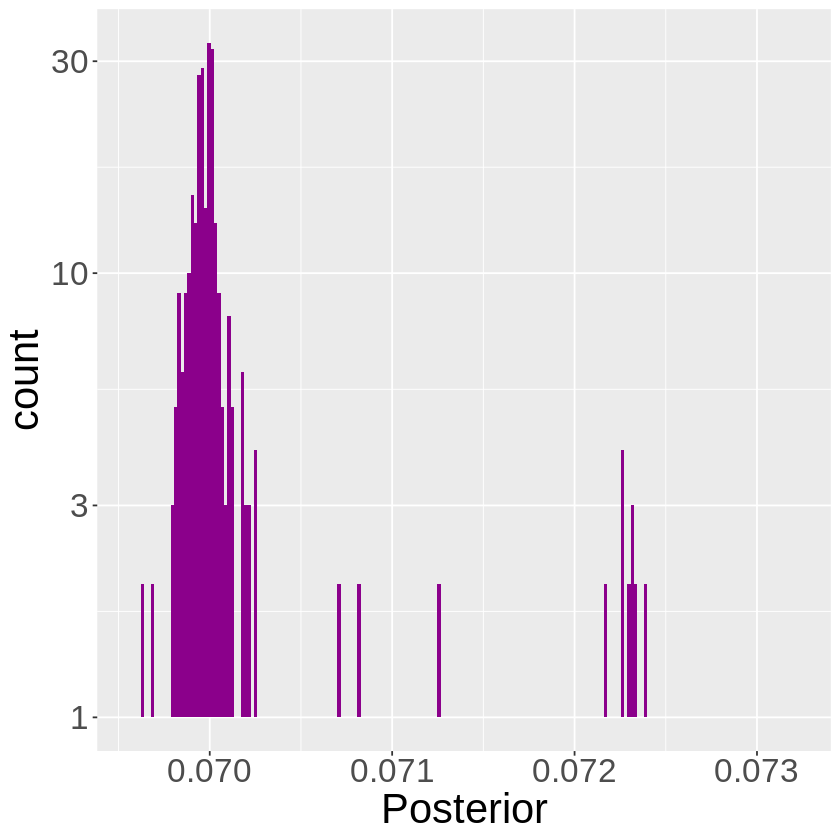

In [34]:
library(ggplot2)
library(WatershedR)

maxn <- function(x, n) {
  partial <- length(x) - n + 1
  x[x >= sort(x, partial = partial)[partial]]
}

s=4
pops = c("ESN")
# TODO combine these instead of plotting separately? 
# But the different Watershed priors may not be comparable, so maybe just use WS trained on full dataset.
top_genes = c()
bot_genes = c()

N = 20
for (pop in pops){
    ws_obj <- readRDS(sprintf("RIVER_n1_30x_%s_seed%s_evaluation_object.rds", pop, s))
    #ws_obj = readRDS(sprintf("RIVER_n1_%s_phyloP-241_seed%s_evaluation_object.rds", pop, s))

    df_pp = data.frame(Posterior=ws_obj$test_posterior)
    #df_pp = data.frame(Posterior=ws_obj$model_params$posterior)
    p <- ggplot(df_pp, aes(x=Posterior)) + 
        geom_histogram(fill="darkmagenta", bins=200) +
        scale_y_log10() +
        theme(text = element_text(size = 25))

    print(p)
    
    # Get top genes from test dataset
    input_file = sprintf("/Volumes/T7/watershed/AF.all.%s.hg38a.ID.ba.VEP.gencode.phyloP.agg.eout.pairs.rare.ws.tsv", pop)
    number_of_dimensions = 1
    n2_pair_pvalue_fraction = 0.1
    binary_pvalue_threshold = 0.1
    data_input <- load_watershed_data(input_file, number_of_dimensions, n2_pair_pvalue_fraction, binary_pvalue_threshold)
    N2_pairs <- data_input$N2_pairs
    feat_all <- data_input$feat
    feat_test <- rbind(feat_all[!is.na(N2_pairs),][seq(from=1,to=sum(!is.na(N2_pairs)),by=2),], 
                       feat_all[!is.na(N2_pairs),][seq(from=2,to=sum(!is.na(N2_pairs)),by=2),])

    #top = maxn(ws_obj$test_posterior, N)
    #topidx = which(ws_obj$test_posterior >= min(top))
    # heuristic to find the midpoint between the 2 clusters of PPs, maybe there's a better way to do this?
    spl = (max(ws_obj$test_posterior) - min(ws_obj$test_posterior)) / 2 + min(ws_obj$test_posterior)
    topidx = which(ws_obj$test_posterior >= spl)
    botidx = which(ws_obj$test_posterior < spl)
    tg = sapply(row.names(feat_test[topidx,]), function(x) strsplit(x, ":")[[1]][2], USE.NAMES=FALSE)
    bg = sapply(row.names(feat_test[botidx,]), function(x) strsplit(x, ":")[[1]][2], USE.NAMES=FALSE)
    top_genes = c(tg, top_genes)
    bot_genes = c(bg, bot_genes)
}
top_genes = list(top_genes)
names(top_genes) = pops
bot_genes = list(bot_genes)
names(bot_genes) = pops

In [37]:
ws_obj$model_params$num_samples
ws_obj$test_posteriors

[1] 341715

0.06963833
0.06983359
0.07216622
0.06995090
0.07004961
0.06996476
0.06994099
0.06987235
0.06996698
0.06994046
0.06995077


#### OpenTargets

In [41]:
library(jsonlite)

gene_ids = c()
tractability = c()

for (i in 0:199) {
    f <- sprintf("/Volumes/T7/OpenTargets/json/targets/part-%05d-642a3cf6-d7c6-4955-b51f-a01ab4695f8b-c000.json", i)
    con <- file(f, open="r")
    jsonlist <- list()
    while (length(line <- readLines(con, n=1, warn = FALSE)) > 0) {
      jsonlist <- append(jsonlist, list(fromJSON(line)))
    }
    close(con)

    for (j in jsonlist) {
        gene_ids = c(gene_ids, j$id)
        t = paste(j$tractability[j$tractability$value, "id"], collapse="; ")
        tractability = c(tractability, t)
    }
}
df_ot = data.frame("GeneID"=gene_ids, "Tractability"=tractability )
row.names(df_ot) = df_ot$GeneID
write.table(df_ot, "/Volumes/T7/OpenTargets/dataframe.tsv", sep="\t")
# run fig1_python.ipynb here to convert this to categorical

In [258]:
df_ot_cat = read.table("/Volumes/T7/OpenTargets/dataframe_cat.tsv", sep="\t", header=T, row.names=1)
df_ot_cat["GeneID"] <- row.names(df_ot_cat)
for (pop in pops){
    tg = top_genes[pop][[1]]
    bg = bot_genes[pop][[1]]    
    tg_ot = df_ot_cat[tg,]
    bg_ot = df_ot_cat[bg,]
}
tg_ot_gg <- tg_ot %>% gather(var, val, -GeneID)
bg_ot_gg <- bg_ot %>% gather(var, val, -GeneID)

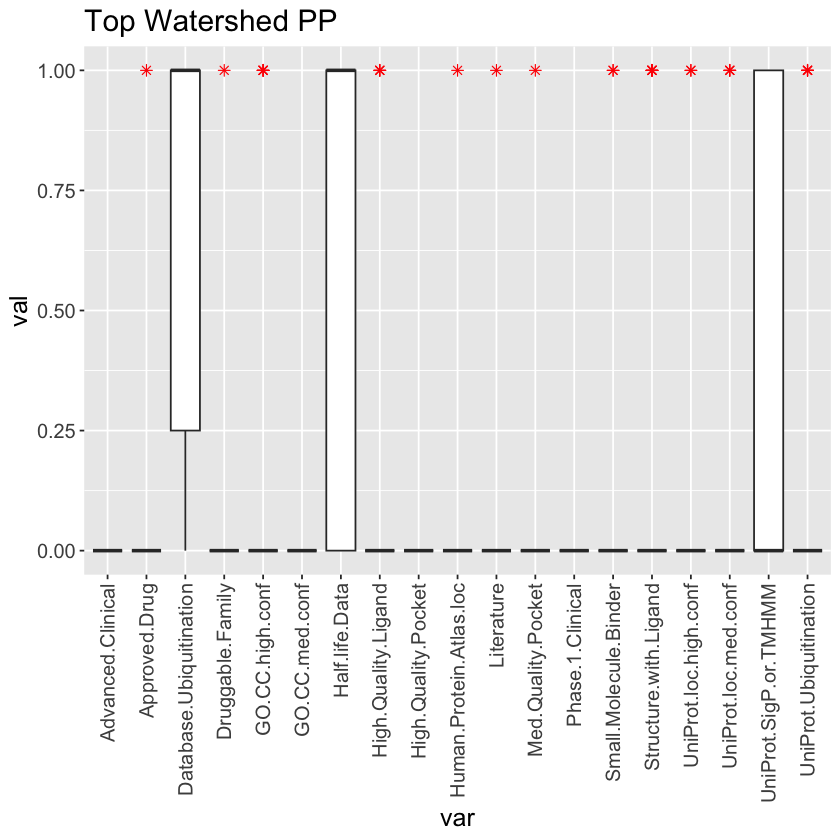

In [267]:
p <- ggplot(tg_ot_gg, aes(y=val, x=var,)) + 
  geom_boxplot(outlier.colour="red", outlier.shape=8,
                outlier.size=2) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  theme(text = element_text(size = 15)) +
  ggtitle("Top Watershed PP")
p


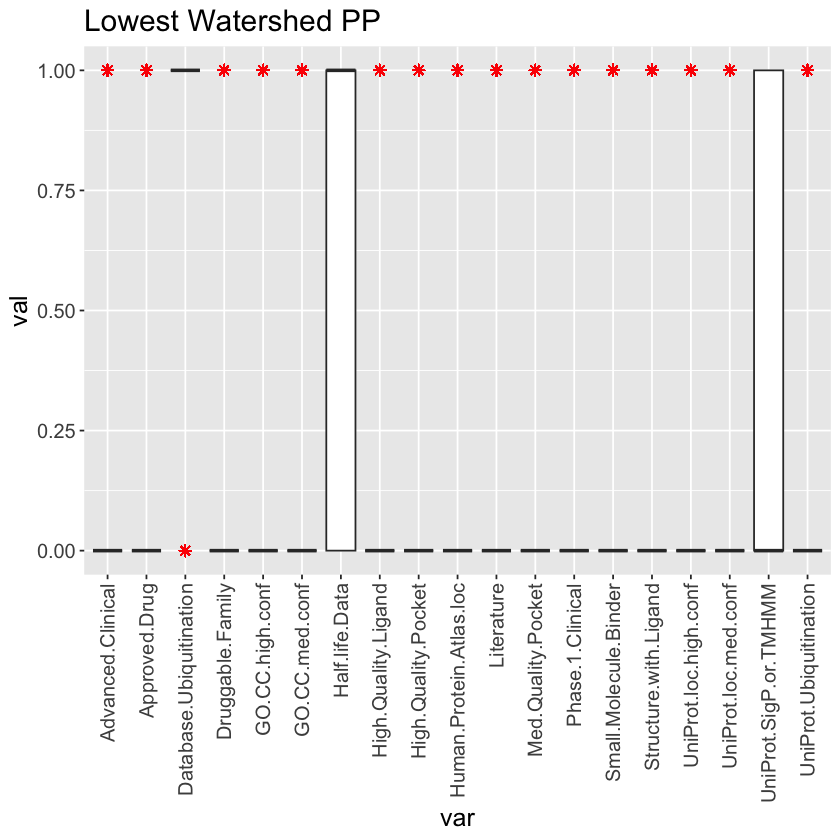

In [268]:
p <- ggplot(bg_ot_gg, aes(y=val, x=var,)) + 
  geom_boxplot(outlier.colour="red", outlier.shape=8, outlier.size=2) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  theme(text = element_text(size = 15)) +
  ggtitle("Lowest Watershed PP")
p


#### OMIM

In [33]:
mim2gene = read.table("/Volumes/T7/OMIM/mim2gene.txt", sep="\t", fill=T, header=T)
genemap = read.table("/Volumes/T7/OMIM/genemap2.txt", sep="\t", fill=T, header=T)
mimtitles = read.table("/Volumes/T7/OMIM/mimTitles.txt", sep="\t", fill=T, header=T)
morbid = read.table("/Volumes/T7/OMIM/morbidmap.txt", sep="\t", fill=T, header=T)

Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”
Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


In [97]:
omim_genes = c()
omim_df = data.frame()
for (t in tg) {
    if (any(t == genemap["Ensembl.Gene.ID"])) {
        omim_genes = c(t, omim_genes)
        omim_df = rbind(omim_df,genemap[t == genemap["Ensembl.Gene.ID"]])
    }
}
colnames(omim_df) = colnames(genemap)                                        

In [98]:
# does this give us "disease causing" somewhere? just if phenotype is present I guess?
omim_df

Chromosome,Genomic.Position.Start,Genomic.Position.End,Cyto.Location,Computed.Cyto.Location,MIM.Number,Gene.Symbols,Gene.Name,Approved.Gene.Symbol,Entrez.Gene.ID,Ensembl.Gene.ID,Comments,Phenotypes,Mouse.Gene.Symbol.ID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr20,17941600,17968794,20p11,20p11.23,605937,SNX5,Sorting nexin 5,SNX5,27131,ENSG00000089006,,,Snx5 (MGI:1916428)
chr5,659862,700727,5p15.3,5p15.33,608773,"TPPP, P25, P24",Tubulin polymerization-promoting protein,TPPP,11076,ENSG00000171368,,,Tppp (MGI:1920198)
chr5,14704800,14871778,5p15.2-p14.1,5p15.2,605145,"ANKH, HANK, ANK, CMDJ, CCAL2, CPPDD",ANKH inorganic pyrophosphate transport regulator,ANKH,56172,ENSG00000154122,,"Chondrocalcinosis 2, 118600 (3), Autosomal dominant; Craniometaphyseal dysplasia, 123000 (3), Autosomal dominant",Ank (MGI:3045421)
chr5,863741,892801,5p15.33,5p15.33,618465,BRD9,Bromodomain-containing protein 9,BRD9,65980,ENSG00000028310,,,Brd9 (MGI:2145317)
chr7,100400872,100428703,7q22.1,7q22.1,618900,ZCWPW1,Zinc finger CW-type domain- and PWWP domain-containing protein 1,ZCWPW1,55063,ENSG00000078487,,,Zcwpw1 (MGI:2685899)


In [99]:
omim_genes = c()
omim_df = data.frame()
for (t in bg) {
    if (any(t == genemap["Ensembl.Gene.ID"])) {
        omim_genes = c(t, omim_genes)
        omim_df = rbind(omim_df,genemap[t == genemap["Ensembl.Gene.ID"]])
    }
}
colnames(omim_df) = colnames(genemap)                                        

In [100]:
omim_df

Chromosome,Genomic.Position.Start,Genomic.Position.End,Cyto.Location,Computed.Cyto.Location,MIM.Number,Gene.Symbols,Gene.Name,Approved.Gene.Symbol,Entrez.Gene.ID,Ensembl.Gene.ID,Comments,Phenotypes,Mouse.Gene.Symbol.ID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr20,50934855,50958564,20q13.13,20q13.13,603503,"DPM1, MPDS, CDGIE","Dolichyl-phosphate mannosyltransferase 1, catalytic subunit",DPM1,8813,ENSG00000000419,,"Congenital disorder of glycosylation, type Ie, 608799 (3), Autosomal recessive",Dpm1 (MGI:1330239)
chr16,90004871,90019890,16q24.3,16q24.3,620388,DBNDD1,Dysbindin domain-containing protein 1,DBNDD1,79007,ENSG00000003249,,,Dbndd1 (MGI:1919435)
chr3,50088919,50119021,3p21.3,3p21.31,606884,"RMB5, LUCA15",RNA-binding motif protein 5,RBM5,10181,ENSG00000003756,,,Rbm5 (MGI:1933204)
chr8,17494069,17570566,8p22,8p22,601872,"SLC7A2, ATRC2, HCAT2","Solute carrier family 7 (cationic amino acid transporter, y+ system), member 2",SLC7A2,6542,ENSG00000003989,,,Slc7a2 (MGI:99828)
chr17,3860315,3893053,17p13.2,17p13.2,611411,"CAMKK1, CAMKKA","Calcium/calmodulin-dependent protein kinase kinase 1, alpha",CAMKK1,84254,ENSG00000004660,,,Camkk1 (MGI:1891766)
chr14,70722526,70809513,14q24.3-q31,14q24.2,600136,"MAP3K9, MLK1",Mitogen-activated protein kinase kinase kinase 9,MAP3K9,4293,ENSG00000006432,,,Map3k9 (MGI:2449952)
chr7,140084746,140176983,7q34,7q34,619640,"KDM7A, JHDM1D, KIAA1718",Lysine demethylase 7A,KDM7A,80853,ENSG00000006459,,,Kdm7a (MGI:2443388)
chr16,1349240,1351878,16p13.3,16p13.3,617058,TSR3,"TSR3, aminocarboxypropyl transferase ribosome maturation factor",TSR3,115939,ENSG00000007520,,,Tsr3 (MGI:1915577)
chr6,16129086,16163887,6p23-p22.3,6p22.3,610082,"MYLIP, MIR",Myosin regulatory light chain-interacting protein,MYLIP,29116,ENSG00000007944,,,Mylip (MGI:2388271)


In [104]:
32735 / length(bg)
5/length(tg) # Hmmmmm it's lower, definitely doensn't seem enriched for OMIM

[1] 0.4215277

[1] 0.1923077

### 1e
For high-scoring RV set, plot AF in AFGR (xscale = min in AFGR to 0.01%, or AFs from gnomad?)  vs. AF in Europe, Asia (e.g. frombiobank?) (1/1000 to 0.01, or whatever scale makes all the datapoints from AFGR fit).

In [ ]:
# TODO write a lil script to tabix query the 1000g file for all the high Watershed PP rare variants, then write out each of the continental AFs.

In [ ]:

gfile = sprintf("20201028_CCDG_14151_B01_GRM_WGS_2020-08-05_chr%s.recalibrated_variants.annotated.vcf.gz", 
                chr)